# **PROYECTO DE GRADO - Parte 1: Preprocesamiento de texto**

---

**Maestría en Analítica de Datos**

**Facultad de Ingeniería y Ciencias Básicas**

**Universidad Central**

---

**INTEGRANTES:**

- Hugo Ernesto Rodríguez Capera
- Jhonny Stiwen Rosero Castro

# Librerias

In [1]:
!pip install stop_words
!pip install unidecode
!pip install word2number
import nltk
nltk.download('stopwords')
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns
from nltk import word_tokenize
from stop_words import get_stop_words
from bs4 import BeautifulSoup
import spacy
import unidecode
import os, os.path, sys
import glob
import random
import time
from sklearn.feature_extraction.text import CountVectorizer

# Cargue de datos

In [4]:
df=pd.read_excel('fallas_2010_2021.xlsx')
s_w=pd.read_excel('Tokens_unicos_fallas2.xlsx',sheet_name='STOPS')
stop_custom = pd.read_excel('Tokens_unicos_fallas2.xlsx',sheet_name='Hoja2')

In [5]:
stop_words=list(s_w.STOPS)
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords=stopwords+stop_words
stopwords.remove('no')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107755 entries, 0 to 107754
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Fecha_Creación_ Aviso       107755 non-null  datetime64[ns]
 1   Reporte                     107755 non-null  int64         
 2   Orden                       101053 non-null  float64       
 3   Matricula                   107755 non-null  object        
 4   ATA                         95824 non-null   object        
 5   Subsistema                  66456 non-null   object        
 6   Componente                  41297 non-null   object        
 7   Descrpcion_ATA/Subsis/Comp  107447 non-null  object        
 8   No_ EQUIPO                  22488 non-null   float64       
 9   Descripcion_Equipo          22488 non-null   object        
 10  Descripcion_Reporte         103713 non-null  object        
 11  Repercusion                 107755 non-

In [7]:
df.columns

Index(['Fecha_Creación_ Aviso', 'Reporte', 'Orden', 'Matricula', 'ATA',
       'Subsistema', 'Componente', 'Descrpcion_ATA/Subsis/Comp', 'No_ EQUIPO',
       'Descripcion_Equipo', 'Descripcion_Reporte', 'Repercusion', 'Flota',
       'Costo_Falla', 'TTR_(HORAS)', 'Indisponibilidad', 'H_totales_aeronave',
       'Horas_Voladas'],
      dtype='object')

# Funciones

In [8]:
def Remover__x000d_(text):
    text=str(text).lower().replace('_x000d_','')
    return text

In [9]:
def extrae_falla(texto):
    patron = re.compile(r'(\d\d\W\d\d\W\d\d\d\d\s\d\d\W\d\d\W\d\d\s)')
    split = patron.split(texto)
    if len(split) == 1:
        return texto
    else:
        try:
            return split[2].split('\n', 1)[1]
        except:
            return split[2]

In [10]:
def M1_falla(texto):
    patron = re.compile('( ac )|(se chequ)|(se peg)|(se corrig)|(se inspecci)|(se intercamb)|(se reempla)|(se verif)|(se ajust)|(se transcrib)|(se cambi)|(accion correctiva)|(acción correctiva)|(se efectu)|(se realiz)|(se revi)|(a/c)|(se remuev)|(se limpi)')
    split = patron.split(texto,1)
    return split[0]

In [11]:
def M1_sol(texto):
    patron = re.compile(r'(\d\d\W\d\d\W\d\d\d\d\s\d\d\W\d\d\W\d\d\s)')
    split = patron.split(texto)
    if len(split)<=3:
        return ''
    else:
        for i in range(1,len(split),2):
            if split[i]!=split[i+2]:
                try:
                    return split[i+3].split('\n', 1)[1]
                except:
                    return split[i+3]
            else:
                return '' 

In [12]:
def M2_sol(texto):
    patron = re.compile('(ac )|(se chequ)|(se peg)|(se corrig)|(se inspecci)|(se intercamb)|(se reempla)|(se verif)|(se ajust)|(se transcrib)|(se cambi)|(accion correctiva)|(se efectu)|(se realiz)|(se revi)|(a/c)|(se remuev)|(se limpi)')
    split = patron.split(texto,1)
    if len(split)==1:
        return ''
    else:
        segunda_lista = [elemento_lista for elemento_lista in split if elemento_lista != None]
        return segunda_lista[-2]+segunda_lista[-1]

In [13]:
def extrae_solucion(texto):
    if M1_sol(texto)=='':
        return M2_sol(texto)
    else:
        return M1_sol(texto)

In [14]:
def borra_text_duplicado(text):
    lista=text.split()
    lista1=[]
    lista2=[]
    for i in range(1,len(lista)-3):
        lista1.append(lista[0])
        lista1.append(lista[1])
        lista1.append(lista[2])
        lista1.append(lista[3])
        if lista1[0]==lista[i]:
            if lista1[1]==lista[i+1]:
                if lista1[2]==lista[i+2]:
                    if lista1[3]==lista[i+3]:
                        lista2.append(lista[0:i])
                    else:
                        lista2.append(lista)
                else:
                    pass
            else:
                pass
        else:
            pass
    if len(lista2)>0:
        return (" ").join(lista2[0])
    else:
        return (" ").join(lista)

In [16]:
listaStop = list(stop_custom['fi'])
def remove_stop_custom(text, lista=listaStop):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [str(word) for word in text_tokens if not word in lista]
    text=(" ").join(tokens_without_sw)
    return text

In [17]:
def remove_stop(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [str(word) for word in text_tokens if not word in stopwords]
    tokens_without_lt = [word for word in tokens_without_sw if len(word)>1]
    text=(" ").join(tokens_without_lt)
    text = unidecode.unidecode(text)
    text = text.strip()
    text = " ".join(text.split())
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords]
    return (" ").join(tokens_without_sw)

In [18]:
def get_top_ngram(corpus, m, n=None):
    vec = CountVectorizer(ngram_range=(m, m)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [19]:
def crea_grafico(lista_tuplas, tipo_ngrama='unigramas'):
    datos=pd.DataFrame(lista_tuplas, columns = [str(tipo_ngrama) , 'Cantidad'])
    plt.figure(figsize=(7,9))
    ax = sns.barplot(data=datos, y= str(tipo_ngrama), x = "Cantidad")
    ax.set(xlabel = 'Cantidad')
    plt.title('Distribución de '+str(tipo_ngrama), size = 20)
    plt.xticks(rotation = 90)
    return plt.show

In [20]:
def Sist_unif(ata):
    if ata in(['71','73','74','76','77','79']):
        ata='72'
        return ata
    else:
        return ata

In [21]:
!spacy download es_core_news_md
!spacy download es
import es_core_news_md
nlp = es_core_news_md.load()

# Retirando el no de las palabras de parada
deselect_stop_words = ['no']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

def remove_letters(text):
    """remove accented characters from text, e.g. café"""
    text = [w for w in text.split() if len(w) > 1]
    return( " ".join(text))  

def text_preprocessing(text, accented_chars=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, 
                       remove_html=True, special_chars=True, 
                       stop_words=True, remove_letter=True):
    global clean_text
    """preprocess text with default option set to true for all steps"""
    if remove_html == True: #Removiendo etiquetas html
        text = strip_html_tags(text)
    if remove_letter == True: #Removiendo palabras con longitud 1
        text = remove_letters(text)
    if extra_whitespace == True: #Removiendo espacios extra
        text = remove_whitespace(text)
    if accented_chars == True: #Removiendo acentos
        text = remove_accented_chars(text)
    if lowercase == True: #Convirtiendo todos los caracteres al mismo nivel
        text = text.lower()

    doc = nlp(text) #Tokenizando el texto

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        #Removiendo stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # removiendo caracteres especiales
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # Lematizando (raíz de la palabra)
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # Generando el nuevo texto preprocesado 
        if edit != "" and flag == True:
            clean_text.append(edit)
    return clean_text

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 39.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 80.8 MB/s eta 0:00:0000:010:01


✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [22]:
def remove_char(text):
    return re.sub("[^A-Za-zóáéíúÁÉÍÓÚüÜñÑ]+",' ', text)

# Preprocesamiento

## Eliminación datos duplicados y nulos de las variables de interés

In [23]:
df['Descripcion_Reporte']=df['Descripcion_Reporte'].apply(lambda x:Remover__x000d_(x))
df.drop_duplicates(['Reporte'], keep='last', inplace=True)
df = df[pd.notnull(df['Descripcion_Reporte'])]
df = df[pd.notnull(df['ATA'])]
borrar=df[df['Descripcion_Reporte']=='nan']
df.drop(borrar.index, inplace=True,axis=0)
df.reset_index(inplace=True, drop=True)
len(df)

91317

## Separación - limpieza de la falla y solución

In [24]:
import multiprocessing as mp
from multiprocessing import Pool

if __name__ == '__main__':
    starttime = time.time()
    pool = Pool()
    lista = pool.map(extrae_falla, df['Descripcion_Reporte'])
    lista = pool.map(borra_text_duplicado, lista)
    lista = pool.map(M1_falla, lista)
    listaFalla = pool.map(remove_stop_custom, lista)
    listaSemiPro = pool.map(remove_stop, listaFalla)
    lista = pool.map(remove_char, listaSemiPro)
    lista = pool.map(text_preprocessing, lista)
    listaPro = [' '.join(i) for i in lista]
    pool.close()
    print('That took {} seconds'.format(time.time() - starttime))

That took 26.560127019882202 seconds


In [25]:
df['Falla_Procesada'] = listaPro
df['Falla_Semi_Procesada'] = listaSemiPro
df['Falla'] = listaFalla

In [26]:
if __name__ == '__main__':
    starttime = time.time()
    pool = Pool()
    lista = pool.map(extrae_solucion, df['Descripcion_Reporte'])
    lista = pool.map(borra_text_duplicado, lista)
    listaSol = pool.map(remove_stop_custom, lista)
    listaSemiPro = pool.map(remove_stop, listaSol)
    lista = pool.map(remove_char, listaSemiPro)
    lista = pool.map(text_preprocessing, lista)
    listaPro = [' '.join(i) for i in lista]
    pool.close()
    print('That took {} seconds'.format(time.time() - starttime))

That took 27.015557289123535 seconds


In [27]:
df['Solucion_Procesada'] = listaPro
df['Solucion_Semi_Procesada'] = listaSemiPro
df['Solucion'] = listaSol

In [28]:
df['Reporte_Semi_Procesado'] = df['Falla_Semi_Procesada'] + ' ' + df['Solucion_Semi_Procesada']
df['Reporte_Procesado'] = df['Falla_Procesada'] + ' ' + df['Solucion_Procesada']

## Ejemplo del procesamiento de la falla y solución

In [29]:
i=random.randrange(0, len(df))
print(i)
print('Información del reporte: '+str(df['Reporte'][i]))
print('*'*60)
print(df['Falla'][i])
print('*'*60)
print(df['Solucion'][i])
print('*'*60)
print(df['Falla_Semi_Procesada'][i])
print('*'*60)
print(df['Solucion_Semi_Procesada'][i])
print('*'*60)
print(df['Falla_Procesada'][i])
print('*'*60)
print(df['Solucion_Procesada'][i])
print('*'*60)
print(df['Reporte_Procesado'][i])

56825
Información del reporte: 10866035
************************************************************
pdu presenta falla discrete no go pdu presenta falla discrete no go
************************************************************

************************************************************
pdu presenta falla discrete no go pdu presenta falla discrete no go
************************************************************

************************************************************
pdu presentar falla discrete no go pdu presentar falla discrete no go
************************************************************

************************************************************
pdu presentar falla discrete no go pdu presentar falla discrete no go 


## Distribución de unigramas, bigramas, trigramas del reporte sin preprocesamiento

<function matplotlib.pyplot.show(close=None, block=None)>

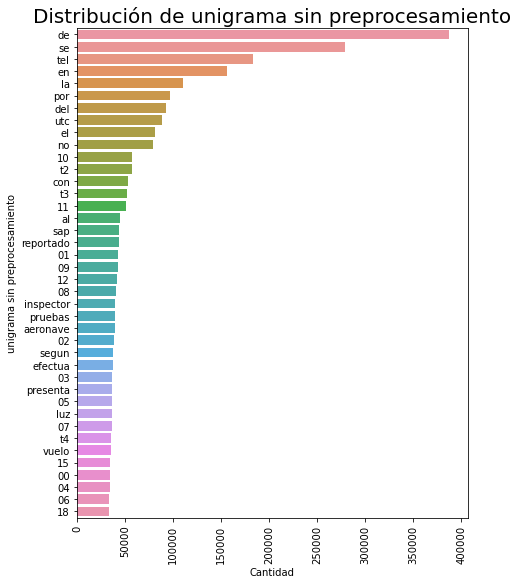

In [30]:
%matplotlib inline
common_words = get_top_ngram(df['Descripcion_Reporte'],1,40)
crea_grafico(common_words, tipo_ngrama='unigrama sin preprocesamiento')

<function matplotlib.pyplot.show(close=None, block=None)>

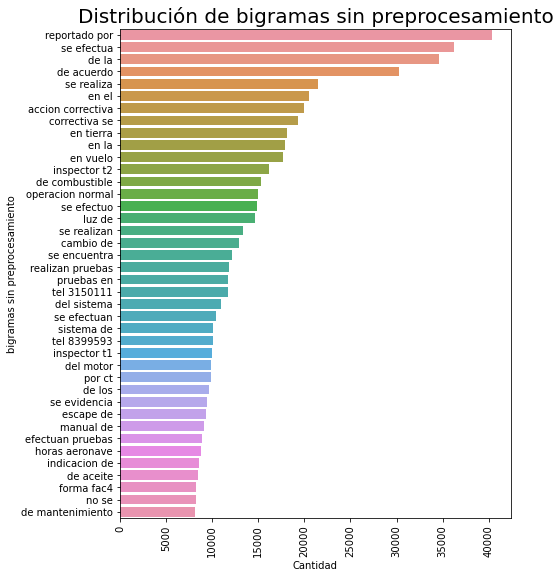

In [31]:
common_words = get_top_ngram(df['Descripcion_Reporte'],2,40)
crea_grafico(common_words, tipo_ngrama='bigramas sin preprocesamiento')

<function matplotlib.pyplot.show(close=None, block=None)>

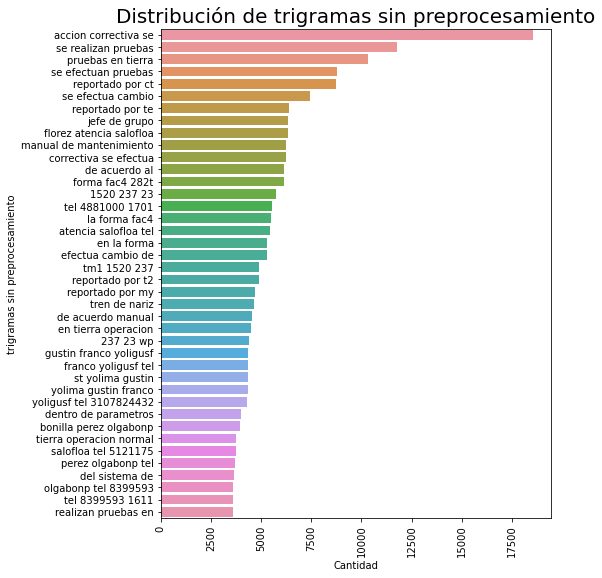

In [32]:
common_words = get_top_ngram(df['Descripcion_Reporte'],3,40)
crea_grafico(common_words, tipo_ngrama='trigramas sin preprocesamiento')

<function matplotlib.pyplot.show(close=None, block=None)>

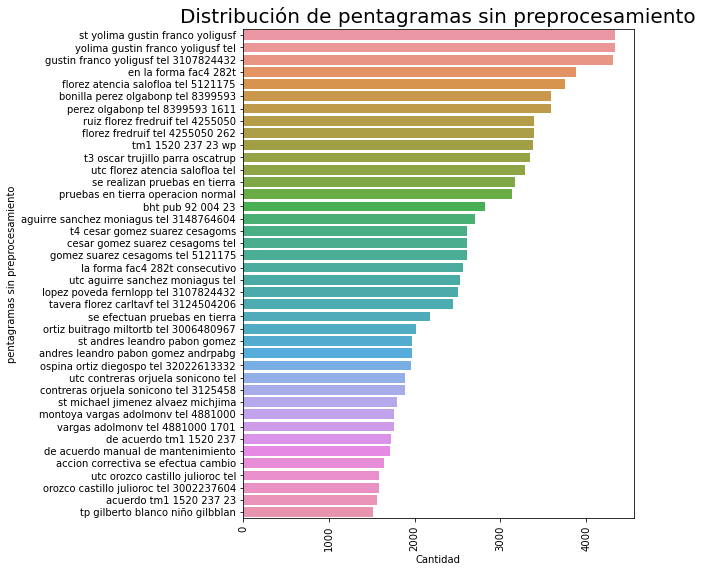

In [33]:
common_words = get_top_ngram(df['Descripcion_Reporte'],5,40)
crea_grafico(common_words, tipo_ngrama='pentagramas sin preprocesamiento')

## Distribución de unigramas, bigramas, trigramas del reporte con preprocesamiento

<function matplotlib.pyplot.show(close=None, block=None)>

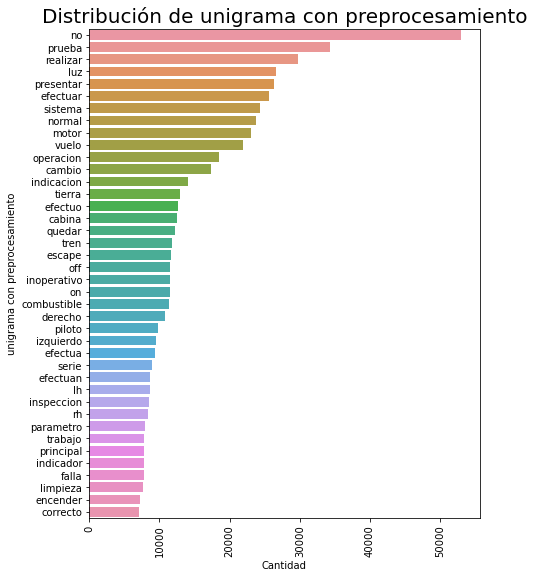

In [34]:
%matplotlib inline
common_words = get_top_ngram(df['Reporte_Procesado'],1,40)
crea_grafico(common_words, tipo_ngrama='unigrama con preprocesamiento')

<function matplotlib.pyplot.show(close=None, block=None)>

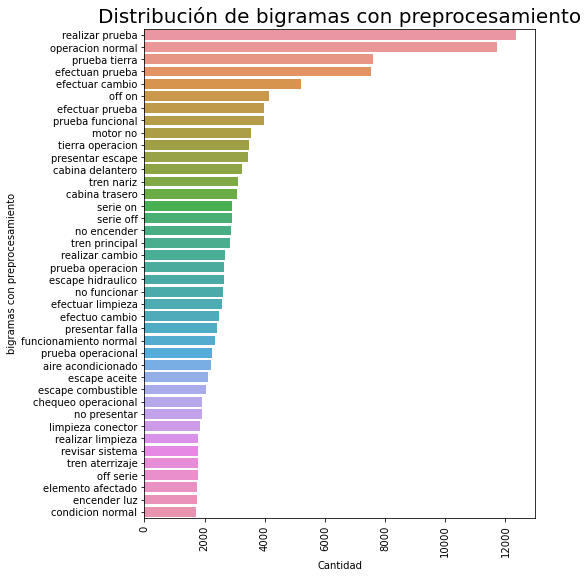

In [35]:
common_words = get_top_ngram(df['Reporte_Procesado'],2,40)
crea_grafico(common_words, tipo_ngrama='bigramas con preprocesamiento')

<function matplotlib.pyplot.show(close=None, block=None)>

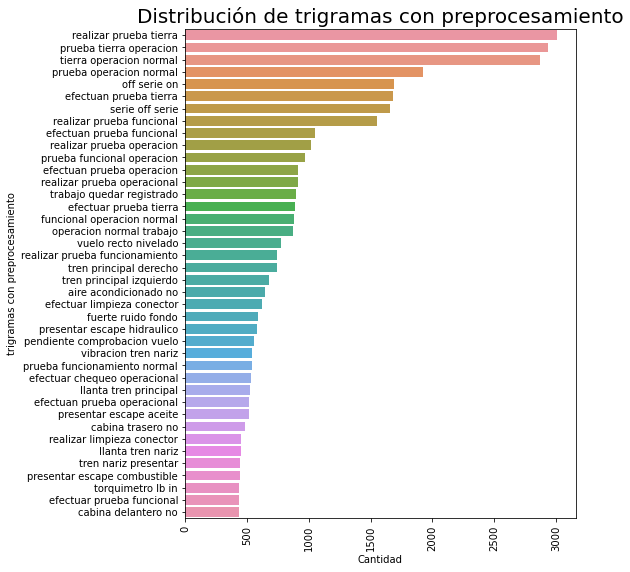

In [36]:
common_words = get_top_ngram(df['Reporte_Procesado'],3,40)
crea_grafico(common_words, tipo_ngrama='trigramas con preprocesamiento')

<function matplotlib.pyplot.show(close=None, block=None)>

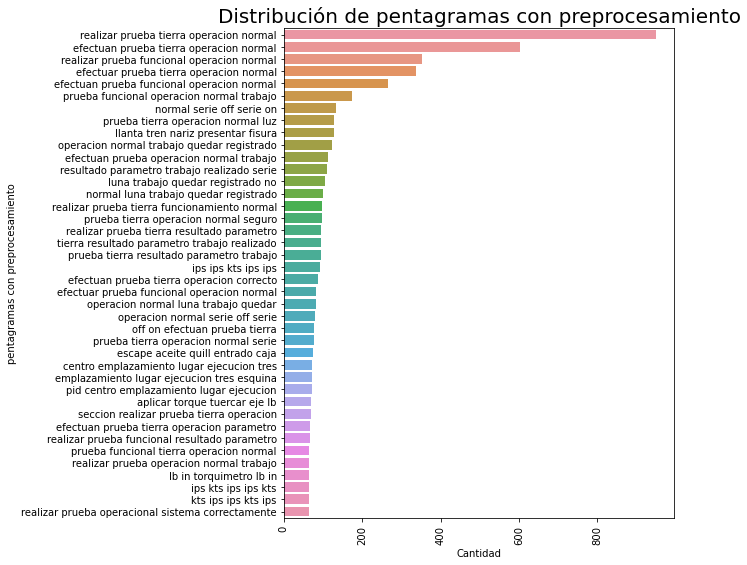

In [37]:
common_words = get_top_ngram(df['Reporte_Procesado'],5,40)
crea_grafico(common_words, tipo_ngrama='pentagramas con preprocesamiento')

## Unificación Sistemas

In [38]:
df['ATA']=df['ATA'].apply(lambda x:Sist_unif(x))

In [39]:
df.dropna(subset=['Reporte_Procesado', 'ATA'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.to_excel('Datos_Procesados.xlsx', sheet_name='Datos')